In [6]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


## Import Beam Excel ch 1

In [7]:
## read  directory 

basepath=os.path.abspath(os.path.join(os.getcwd()))
excelpath=os.path.join(basepath,'BP - V33_EA_ch1.xlsx')
BP_ch1=pd.read_excel(excelpath)
BP_ch1

,TIME,LOAD_PAC,CH,RISE,COUN,ENER,DURATION,AMP,A-FRQ,RMS,ASL,PCNTS,THR,R-FRQ,I-FRQ,SIG STRNGTH,ABS-ENERGY,load level
0,182.146238,-25.82450,1,220,26,4,467,46,56,0.0002,10,17,40,36,77,25751,4113.0,WITHOUT_CLASIFY
1,182.147574,-19.53350,1,932,194,42,2970,57,65,0.0052,37,55,40,68,59,265621,83236.0,WITHOUT_CLASIFY
2,182.151222,-39.97925,1,130,293,123,2834,68,103,0.0052,37,16,40,102,123,774221,399191.0,WITHOUT_CLASIFY
3,192.398993,246.26125,1,9,21,2,270,47,78,0.0002,10,2,40,72,222,17989,3404.0,LL1_RISE
4,195.300359,324.89875,1,191,9,2,357,45,25,0.0002,10,6,40,18,31,15177,2040.0,LL1_RISE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14541,5941.220293,4941.96850,1,414,21,5,689,46,30,0.0002,10,12,40,32,28,36691,5597.0,WITHOUT_CLASIFY
14542,5941.394401,4938.82300,1,76,17,2,248,47,69,0.0002,10,7,40,58,92,15082,2869.0,WITHOUT_CLASIFY
14543,5942.457182,4929.38650,1,240,44,9,898,48,49,0.0002,10,20,40,36,83,56340,9878.0,WITHOUT_CLASIFY
14544,5947.666662,4919.42575,1,137,10,1,225,42,44,0.0002,10,6,40,45,43,10959,1702.0,WITHOUT_CLASIFY


In [ ]:
#Start Unsupervised clustering 


#0.Extraer solo las etapas que tengan Rise en la columna load_leve y unirlos en un dataframe
#1.Escalar
#2.Para cada etapa
#2.1.Seleccionar mejores features de acuerdo al Laplacian score
#3.1.Aplicar Principal Component y seleccionar las tres Componentes principales
#3.2.Determinar el numero de cluster para cada etapa a partir de Silloute Score 
#3.3.Aplicar Kmeans con las componentes principales y hacer el clustering
#3.4.Mostrar analisis de clusters y que nos dicen cada cluster a partir de cada parametro


### DBSCAN APROACH

### Seleccion de parametros para el eps, grafico de codo

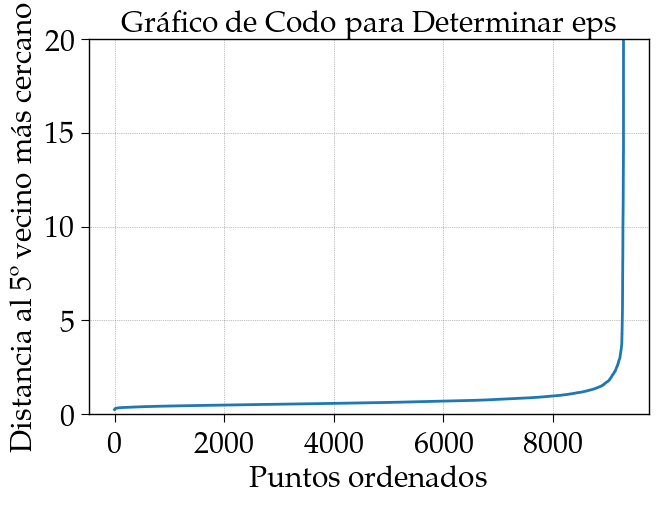

In [15]:
data=BP_ch1

# Filtrar filas donde 'load_level' contiene 'RISE'
data_rise = data[data['load level'].str.contains('RISE', case=False, na=False)]

# Seleccionar solo columnas relevantes para clustering
data_rise_filtered = data_rise.loc[:, 'RISE':'ABS-ENERGY']
data_rise_filtered = data_rise_filtered.select_dtypes(include=[np.number])

# Estandarizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_rise_filtered)

# Generar gráfico de codo para elegir eps
def plot_knee_curve(data):
    neighbors = NearestNeighbors(n_neighbors=5)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)

    # Ordenar las distancias de menor a mayor
    distances = np.sort(distances[:, 4])  # Usamos el 5º vecino más cercano

    # Graficar las distancias ordenadas
    plt.figure(figsize=(8, 5))
    plt.plot(distances, linewidth=2)
    plt.title('Gráfico de Codo para Determinar eps')
    plt.xlabel('Puntos ordenados')
    plt.ylim(0,20)
    plt.ylabel('Distancia al 5º vecino más cercano')
    plt.grid()
    plt.show()

# Llamar a la función para graficar el codo
plot_knee_curve(scaled_data)

#### EPS=5 Y SAMPLES=5

In [17]:
# Función para realizar clustering por nivel de carga y ciclo
def perform_clustering(data, eps=5, min_samples=5):
    clustering_results = {}

    for load_level in data['load level'].unique():
        subset = data[data['load level'] == load_level].copy()
        
        # Seleccionar solo columnas relevantes para clustering
        relevant_columns = subset.loc[:, 'RISE':'ABS-ENERGY']
        numeric_data = relevant_columns.select_dtypes(include=[np.number])

        if numeric_data.empty:
            print(f"No numeric data found for {load_level}")
            continue

        # Estandarizar los datos
        scaled_data = scaler.fit_transform(numeric_data)

        # Aplicar DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(scaled_data)
        
        # Agregar los resultados de clustering
        
        #subset['cluster'] = db.labels_
        # Agregar los resultados de clustering
        subset.loc[:, 'cluster'] = db.labels_

        clustering_results[load_level] = subset

        # Mostrar el número de clusters
        n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
        print(f"{load_level}: {n_clusters} cluster(s)")

    return clustering_results

# Ejecutar el clustering
clustering_results = perform_clustering(data_rise)

# Guardar los resultados
for load_level, df in clustering_results.items():
    output_file = f"clustering_results_{load_level}.xlsx"
    #df.to_excel(output_file, index=False)
    print(f"Resultados para {load_level} guardados en {output_file}")


LL1_RISE: 1 cluster(s)
LL1B_RISE: 0 cluster(s)
LL2A_RISE: 2 cluster(s)
LL2B_RISE: 1 cluster(s)
LL3A_RISE: 2 cluster(s)
LL3B_RISE: 1 cluster(s)
LL4A_RISE: 2 cluster(s)
LL4B_RISE: 1 cluster(s)
LL5A_RISE: 1 cluster(s)
LL5B_RISE: 1 cluster(s)
LL6A_RISE: 1 cluster(s)
Resultados para LL1_RISE guardados en clustering_results_LL1_RISE.xlsx
Resultados para LL1B_RISE guardados en clustering_results_LL1B_RISE.xlsx
Resultados para LL2A_RISE guardados en clustering_results_LL2A_RISE.xlsx
Resultados para LL2B_RISE guardados en clustering_results_LL2B_RISE.xlsx
Resultados para LL3A_RISE guardados en clustering_results_LL3A_RISE.xlsx
Resultados para LL3B_RISE guardados en clustering_results_LL3B_RISE.xlsx
Resultados para LL4A_RISE guardados en clustering_results_LL4A_RISE.xlsx
Resultados para LL4B_RISE guardados en clustering_results_LL4B_RISE.xlsx
Resultados para LL5A_RISE guardados en clustering_results_LL5A_RISE.xlsx
Resultados para LL5B_RISE guardados en clustering_results_LL5B_RISE.xlsx
Resultado

### EPS=3, Y valor dinámico para min_samples basado en el tamaño del nivel

In [18]:
data=BP_ch1

# Filtrar filas donde 'load_level' contiene 'RISE'
data_rise = data[data['load level'].str.contains('RISE', case=False, na=False)]

# Seleccionar solo columnas relevantes para clustering (excluyendo CH y THR)
columns_to_exclude = ['CH', 'THR']
data_rise_filtered = data_rise.drop(columns=columns_to_exclude, errors='ignore').loc[:, 'RISE':'ABS-ENERGY']
data_rise_filtered = data_rise_filtered.select_dtypes(include=[np.number])

# Estandarizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_rise_filtered)

#
# Función para realizar clustering por nivel de carga y ciclo
def perform_clustering(data, eps=2):
    clustering_results = {}

    for load_level in data['load level'].unique():
        subset = data[data['load level'] == load_level].copy()

        # Mostrar la cantidad de filas en el nivel actual
        print(f"{load_level}: {len(subset)} filas")
        
        # Seleccionar solo columnas relevantes para clustering
        relevant_columns = subset.drop(columns=columns_to_exclude, errors='ignore').loc[:, 'RISE':'ABS-ENERGY']
        numeric_data = relevant_columns.select_dtypes(include=[np.number])

        if numeric_data.empty:
            print(f"No numeric data found for {load_level}")
            continue

        # Estandarizar los datos
        scaled_data = scaler.fit_transform(numeric_data)

        # Definir un valor dinámico para min_samples basado en el tamaño del nivel
        min_samples = max(2, min(10, len(subset)))

        # Aplicar DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(scaled_data)
        
        # Agregar los resultados de clustering
        #subset['cluster'] = db.labels_
        subset.loc[:,'cluster'] = db.labels_
        clustering_results[load_level] = subset

        # Mostrar el número de clusters
        n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
        print(f"{load_level}: {n_clusters} cluster(s) (min_samples={min_samples})")

        # Calcular el porcentaje de cada cluster
        cluster_counts = subset['cluster'].value_counts(normalize=True) * 100
        print(f"Porcentaje de puntos por cluster en {load_level}:")
        print(cluster_counts)

    return clustering_results

# Ejecutar el clustering
clustering_results = perform_clustering(data_rise)

# Guardar los resultados
for load_level, df in clustering_results.items():
    output_file = f"clustering_results_{load_level}.xlsx"
    #df.to_excel(output_file, index=False)
    print(f"Resultados para {load_level} guardados en {output_file}")


LL1_RISE: 25 filas
LL1_RISE: 1 cluster(s) (min_samples=10)
Porcentaje de puntos por cluster en LL1_RISE:
cluster
-1    56.0
 0    44.0
Name: proportion, dtype: float64
LL1B_RISE: 2 filas
LL1B_RISE: 0 cluster(s) (min_samples=2)
Porcentaje de puntos por cluster en LL1B_RISE:
cluster
-1    100.0
Name: proportion, dtype: float64
LL2A_RISE: 657 filas
LL2A_RISE: 2 cluster(s) (min_samples=10)
Porcentaje de puntos por cluster en LL2A_RISE:
cluster
 0    92.541857
-1     5.936073
 1     1.522070
Name: proportion, dtype: float64
LL2B_RISE: 45 filas
LL2B_RISE: 1 cluster(s) (min_samples=10)
Porcentaje de puntos por cluster en LL2B_RISE:
cluster
 0    53.333333
-1    46.666667
Name: proportion, dtype: float64
LL3A_RISE: 1575 filas
LL3A_RISE: 1 cluster(s) (min_samples=10)
Porcentaje de puntos por cluster en LL3A_RISE:
cluster
 0    94.349206
-1     5.650794
Name: proportion, dtype: float64
LL3B_RISE: 337 filas
LL3B_RISE: 1 cluster(s) (min_samples=10)
Porcentaje de puntos por cluster en LL3B_RISE:
cl

## Import Beam Excel ch 3

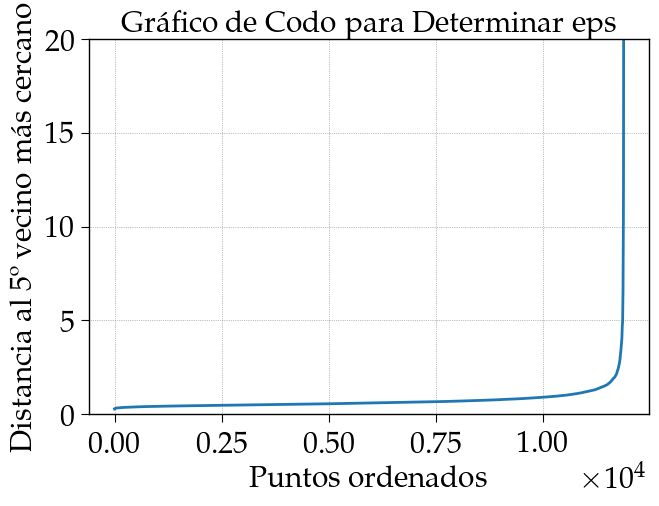

In [2]:
## read  directory 

basepath=os.path.abspath(os.path.join(os.getcwd()))
excelpath=os.path.join(basepath,'BP - V33_EA_ch3.xlsx')
BP_ch3=pd.read_excel(excelpath)
BP_ch3
data=BP_ch3

# Filtrar filas donde 'load_level' contiene 'RISE'
data_rise = data[data['load level'].str.contains('RISE', case=False, na=False)]

# Seleccionar solo columnas relevantes para clustering
data_rise_filtered = data_rise.loc[:, 'RISE':'ABS-ENERGY']
data_rise_filtered = data_rise_filtered.select_dtypes(include=[np.number])

# Estandarizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_rise_filtered)

# Generar gráfico de codo para elegir eps
def plot_knee_curve(data):
    neighbors = NearestNeighbors(n_neighbors=5)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)

    # Ordenar las distancias de menor a mayor
    distances = np.sort(distances[:, 4])  # Usamos el 5º vecino más cercano

    # Graficar las distancias ordenadas
    plt.figure(figsize=(8, 5))
    plt.plot(distances, linewidth=2)
    plt.title('Gráfico de Codo para Determinar eps')
    plt.xlabel('Puntos ordenados')
    plt.ylim(0,20)
    plt.ylabel('Distancia al 5º vecino más cercano')
    plt.grid()
    plt.show()

# Llamar a la función para graficar el codo
plot_knee_curve(scaled_data)

### EPS=3, Y valor dinámico para min_samples basado en el tamaño del nivel

In [5]:
data=BP_ch3

# Filtrar filas donde 'load_level' contiene 'RISE'
data_rise = data[data['load level'].str.contains('RISE', case=False, na=False)]

# Seleccionar solo columnas relevantes para clustering (excluyendo CH y THR)
columns_to_exclude = ['CH', 'THR']
data_rise_filtered = data_rise.drop(columns=columns_to_exclude, errors='ignore').loc[:, 'RISE':'ABS-ENERGY']
data_rise_filtered = data_rise_filtered.select_dtypes(include=[np.number])

# Estandarizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_rise_filtered)

#
# Función para realizar clustering por nivel de carga y ciclo
def perform_clustering(data, eps=2):
    clustering_results = {}

    for load_level in data['load level'].unique():
        subset = data[data['load level'] == load_level].copy()

        # Mostrar la cantidad de filas en el nivel actual
        print(f"{load_level}: {len(subset)} filas")
        
        # Seleccionar solo columnas relevantes para clustering
        relevant_columns = subset.drop(columns=columns_to_exclude, errors='ignore').loc[:, 'RISE':'ABS-ENERGY']
        numeric_data = relevant_columns.select_dtypes(include=[np.number])

        if numeric_data.empty:
            print(f"No numeric data found for {load_level}")
            continue

        # Estandarizar los datos
        scaled_data = scaler.fit_transform(numeric_data)

        # Definir un valor dinámico para min_samples basado en el tamaño del nivel
        min_samples = max(2, min(10, len(subset)))

        # Aplicar DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(scaled_data)
        
        # Agregar los resultados de clustering
        #subset['cluster'] = db.labels_
        subset.loc[:,'cluster'] = db.labels_
        clustering_results[load_level] = subset

        # Mostrar el número de clusters
        n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
        print(f"{load_level}: {n_clusters} cluster(s) (min_samples={min_samples})")

        # Calcular el porcentaje de cada cluster
        cluster_counts = subset['cluster'].value_counts(normalize=True) * 100
        #print(f"Porcentaje de puntos por cluster en {load_level}:")
        #print(cluster_counts)

    return clustering_results

# Ejecutar el clustering
clustering_results = perform_clustering(data_rise)

# Guardar los resultados
for load_level, df in clustering_results.items():
    output_file = f"clustering_results_{load_level}.xlsx"
    #df.to_excel(output_file, index=False)
    print(f"Resultados para {load_level} guardados en {output_file}")


LL1_RISE: 26 filas
LL1_RISE: 0 cluster(s) (min_samples=10)
LL1B_RISE: 4 filas
LL1B_RISE: 0 cluster(s) (min_samples=4)
LL2A_RISE: 492 filas
LL2A_RISE: 1 cluster(s) (min_samples=10)
LL2B_RISE: 55 filas
LL2B_RISE: 1 cluster(s) (min_samples=10)
LL3A_RISE: 1975 filas
LL3A_RISE: 1 cluster(s) (min_samples=10)
LL3B_RISE: 358 filas
LL3B_RISE: 1 cluster(s) (min_samples=10)
LL4A_RISE: 2911 filas
LL4A_RISE: 1 cluster(s) (min_samples=10)
LL4B_RISE: 770 filas
LL4B_RISE: 1 cluster(s) (min_samples=10)
LL5A_RISE: 3253 filas
LL5A_RISE: 1 cluster(s) (min_samples=10)
LL5B_RISE: 874 filas
LL5B_RISE: 1 cluster(s) (min_samples=10)
LL6A_RISE: 1171 filas
LL6A_RISE: 1 cluster(s) (min_samples=10)
Resultados para LL1_RISE guardados en clustering_results_LL1_RISE.xlsx
Resultados para LL1B_RISE guardados en clustering_results_LL1B_RISE.xlsx
Resultados para LL2A_RISE guardados en clustering_results_LL2A_RISE.xlsx
Resultados para LL2B_RISE guardados en clustering_results_LL2B_RISE.xlsx
Resultados para LL3A_RISE guard